In [1]:
from src.ssunet.datasets import BinomDataset, ValidationDataset
from src.ssunet.models import Bit2Bit
from src.ssunet.configs import load_config
from src.ssunet.constants import DEFAULT_CONFIG_PATH

config = load_config(DEFAULT_CONFIG_PATH)

# Load data for training and validation, ground truth for validation metrics
data = config.path_config.load_data_only()
validation_data = config.path_config.load_reference_and_ground_truth()

# Load data configurations and disable augmentation for validation
data_config = config.data_config
validation_config = data_config.validation_config

# Create training and validation datasets
training_data = BinomDataset(data, data_config, config.split_params)
validation_data = ValidationDataset(validation_data, validation_config)

# Create model
model = Bit2Bit(config.model_config)
model.trainer = config.train_config.trainer

# Create data loaders
training_loader = config.loader_config.loader(training_data)
validation_loader = config.loader_config.loader(validation_data)

# Print the input size
print(f"input_size: {tuple(next(iter(training_loader))[1].shape)}")

# Train the model
trainer = config.train_config.trainer
trainer.fit(model, training_loader, validation_loader)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


In [3]:
trainer.save_checkpoint(config.train_config.default_root_dir / "model.ckpt")


In [ ]:
type(data.primary_data)

In [ ]:
from src.tools.gpuinference import gpu_patch_inference
import numpy as np
from tifffile import imwrite

output = gpu_patch_inference(
    model,
    data.primary_data.astype(np.float32),
    min_overlap=48,
    initial_patch_depth=64,
    device=config.train_config.device_numbers,
)

imwrite(config.train_config.default_root_dir / "input.tif", data.primary_data)
imwrite(config.train_config.default_root_dir / "inference.tif", output)

In [52]:
from importlib import reload
import src.tools.tools
import src.tools.metrics
from src.tools.tools import clear_vram
reload(src.tools.tools)
reload(src.tools.metrics)

clear_vram()


In [ ]:
import sys
sys.modules

In [53]:
from src.tools.tools import group_metrics
from tifffile import imread


input_new = data.primary_data.astype(np.float32)[:512].copy()
output_new = output[:512].copy()
ground_truth = imread(config.path_config.ground_truth_file)[:512].astype(np.float32).copy()

print(np.max(input_new), np.max(output_new), np.max(ground_truth))

group_metrics(input_new, output_new, ground_truth, config.train_config.default_root_dir)


1.0 0.92927814 201.0
0.11569165996476716 2.3868983 0.0 0.92927814 0.0 0.7882353 0.0


AssertionError: Input must be normalized to [0, 1], but got min=0.0000, max=2.3573

In [51]:
from src.tools.tools import group_metrics
input = data.primary_data.astype(np.float32)[:512].copy()
image = output[:512].copy()
ground_truth = imread(config.path_config.ground_truth_file)[:512].astype(np.float32).copy()

print(np.max(input), np.max(image), np.max(ground_truth))

group_metrics(input, image, ground_truth, config.train_config.default_root_dir, device=config.train_config.device_numbers)

1.0 0.92927814 201.0
0.11569165996476716 2.3868983 0.0 0.92927814 0.0 0.7882353 0.0


AssertionError: Input must be normalized to [0, 1], but got min=0.0000, max=2.3573

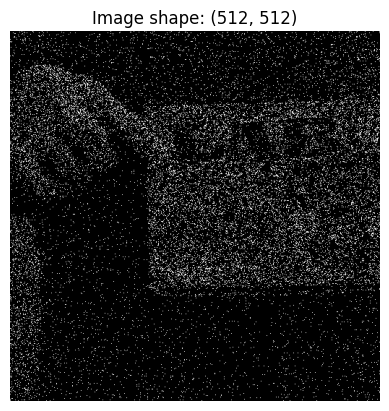

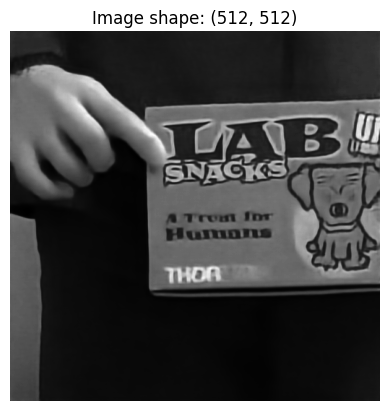

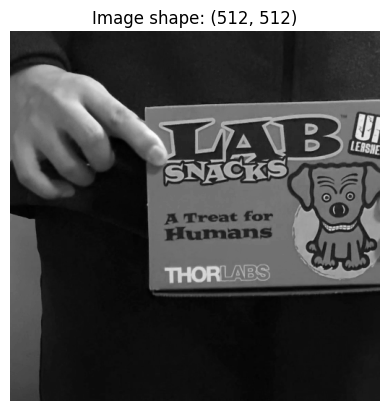

In [37]:
from src.tools.tools import show_image

show_image(input[256])
show_image(output[256])
show_image(ground_truth[256])


In [38]:
np.max(input), np.max(output), np.max(ground_truth), np.min(input), np.min(output), np.min(ground_truth)


(2.3868983, 0.92927814, 201.0, 0.0, 0.0, 0.0)